In [1]:
import re
import joblib
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from dython.nominal import associations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix

**LOAD DATASET**

In [3]:
#read data
data = pd.read_csv('./data/loan_data_2007_2014.csv')
df = pd.DataFrame(data)

#read data description
data_desc = pd.read_excel("./data/LCDataDictionary.xlsx", sheet_name="browseNotes")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**ABOUT DATA**

In [4]:
#read the first 5 rows
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#show data description
data_desc[["Variable","Description"]]

,Variable,Description
0,acceptD,The date which the borrower accepted the offer
1,accNowDelinq,The number of accounts on which the borrower i...
2,accOpenPast24Mths,Number of trades opened in past 24 months.
3,addrState,The state provided by the borrower in the loan...
4,annual_inc_joint,The combined self-reported annual income provi...
...,...,...
103,inq_fi,Number of personal finance inquiries
104,total_cu_t,Number of finance trades
105,inq_last_12m,Number of credit inquiries in past 12 months
106,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

**EXPLORATORY DATA ANALYSIS (EDA)**

In [9]:
title_font = dict(size=20, weight="bold")

def plot_sum(df, y, title, **sns_kwargs):
    value_counts = df[y].value_counts()
    percentage = value_counts / value_counts.sum()
    percentage = percentage.apply("{:.3%}".format)

    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.countplot(data=df, y=y, order=value_counts.index, **sns_kwargs)
    plt.ylabel("")
    plt.show()

    print(percentage)


def plot_dist(df, x, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.histplot(data=df, x=x, kde=True, **sns_kwargs)
    plt.ylabel("")
    plt.show()


def plot_box(df, x, y, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.boxplot(data=df, x=x, y=y, **sns_kwargs)
    plt.ylabel("")
    plt.show()
    plt.show()

*   **LOAN STATUS**

From the picture above, it can be seen that the most loan statuses are "Current" status, with the ratio of successful "Fully Paid" loans more than those that are not (late). This means that the loan status shows a positive trend.

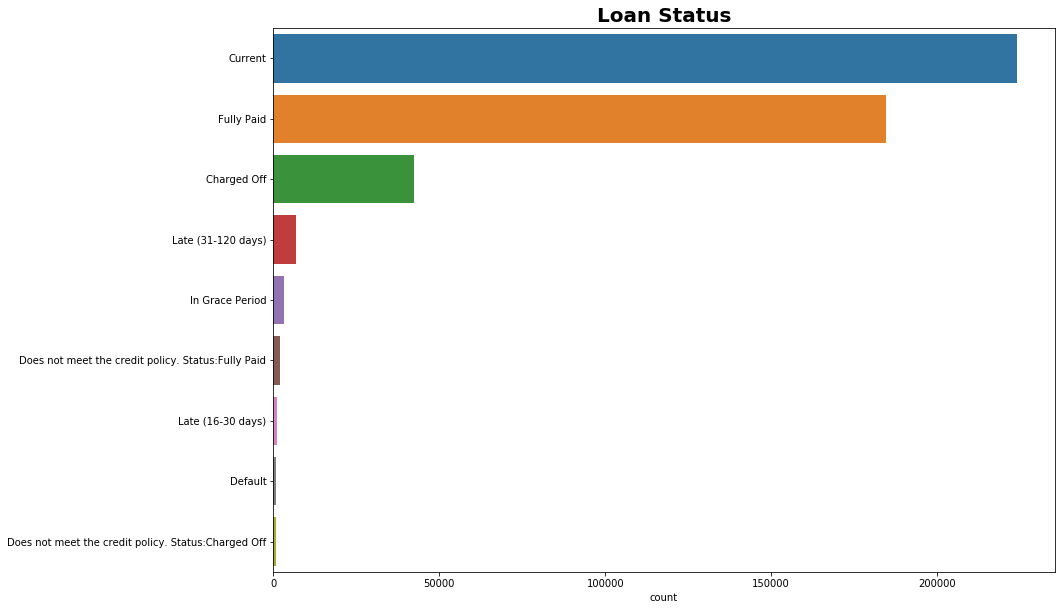

Current                                                48.088%
Fully Paid                                             39.619%
Charged Off                                             9.109%
Late (31-120 days)                                      1.480%
In Grace Period                                         0.675%
Does not meet the credit policy. Status:Fully Paid      0.426%
Late (16-30 days)                                       0.261%
Default                                                 0.178%
Does not meet the credit policy. Status:Charged Off     0.163%
Name: loan_status, dtype: object


In [10]:
plot_sum(df, title="Loan Status",  y="loan_status")

In [11]:
#decide which category to use

approved = ["Fully Paid"]
reject = [
    "Charged Off",
    "Default",
    "Does not meet the credit policy. Status:Fully Paid",
    "Does not meet the credit policy. Status:Charged Off"
]

#replace with new label
def label_loan_status(value):
    if value in approved:
        return 1
    return 0

label_loan_status("Fully Paid")

1

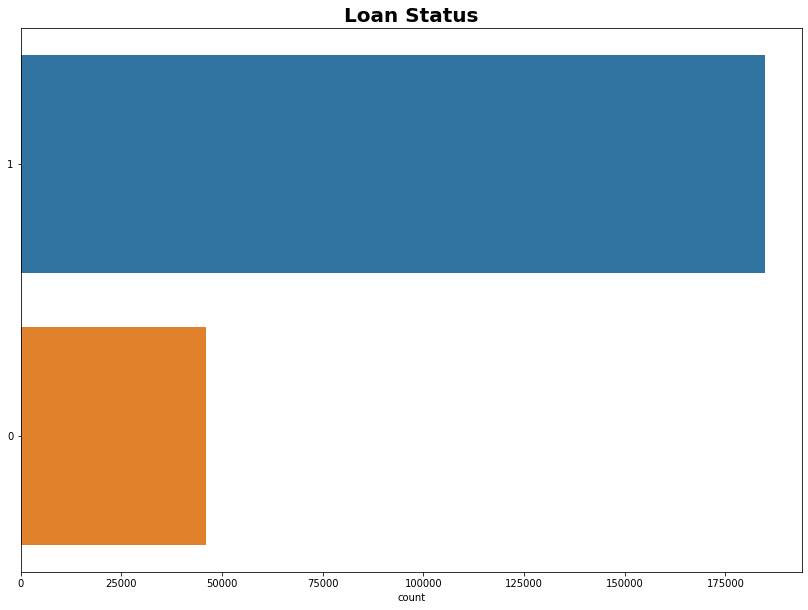

1    80.045%
0    19.955%
Name: loan_status, dtype: object


In [23]:
#filter and apply function
filter_df = df[df["loan_status"].isin(approved + reject)].copy()
filter_df["loan_status"] = filter_df["loan_status"].apply(label_loan_status)

plot_sum(filter_df, y="loan_status", title="Loan Status")

*   **Correlation between variable**

In [24]:
#calculate the correlation of each variable
correlations = (filter_df.select_dtypes(exclude=object)
                         .corr()
                         .dropna(how="all", axis=1)
                         .dropna(how="all", axis=0)
)

In [26]:
correlations["loan_status"].abs().sort_values(ascending=True)

tot_coll_amt                   0.001637
collections_12_mths_ex_med     0.005582
pub_rec                        0.006355
acc_now_delinq                 0.006406
Unnamed: 0                     0.006701
mths_since_last_major_derog    0.010022
revol_bal                      0.011371
open_acc                       0.013934
id                             0.016260
member_id                      0.016778
delinq_2yrs                    0.019631
mths_since_last_delinq         0.029299
total_acc                      0.030680
total_rec_int                  0.032997
installment                    0.033419
funded_amnt_inv                0.039854
funded_amnt                    0.048790
loan_amnt                      0.049253
total_rev_hi_lim               0.052931
annual_inc                     0.061623
mths_since_last_record         0.062190
tot_cur_bal                    0.076230
revol_util                     0.089180
out_prncp_inv                  0.099814
out_prncp                      0.099816


In [30]:
#filter the correlation between vmin - vmax
vmax, vmin = 0.99, 0.1

unstack_corr = correlations.unstack()
pstv_corr = (unstack_corr > vmin) & (unstack_corr < vmax)
ngtv_corr = (unstack_corr > -vmax) & (unstack_corr < -vmin)
high_corr = unstack_corr[pstv_corr | ngtv_corr]

trimmed_corr = high_corr.sort_values(ascending=True).unstack()

In [33]:
#create a mask to form the lower triangular matrix
mask = np.zeros_like(trimmed_corr)
mask[np.triu_indices_from(mask)] = False


Heatmap to see several variables that have an influence on loan status

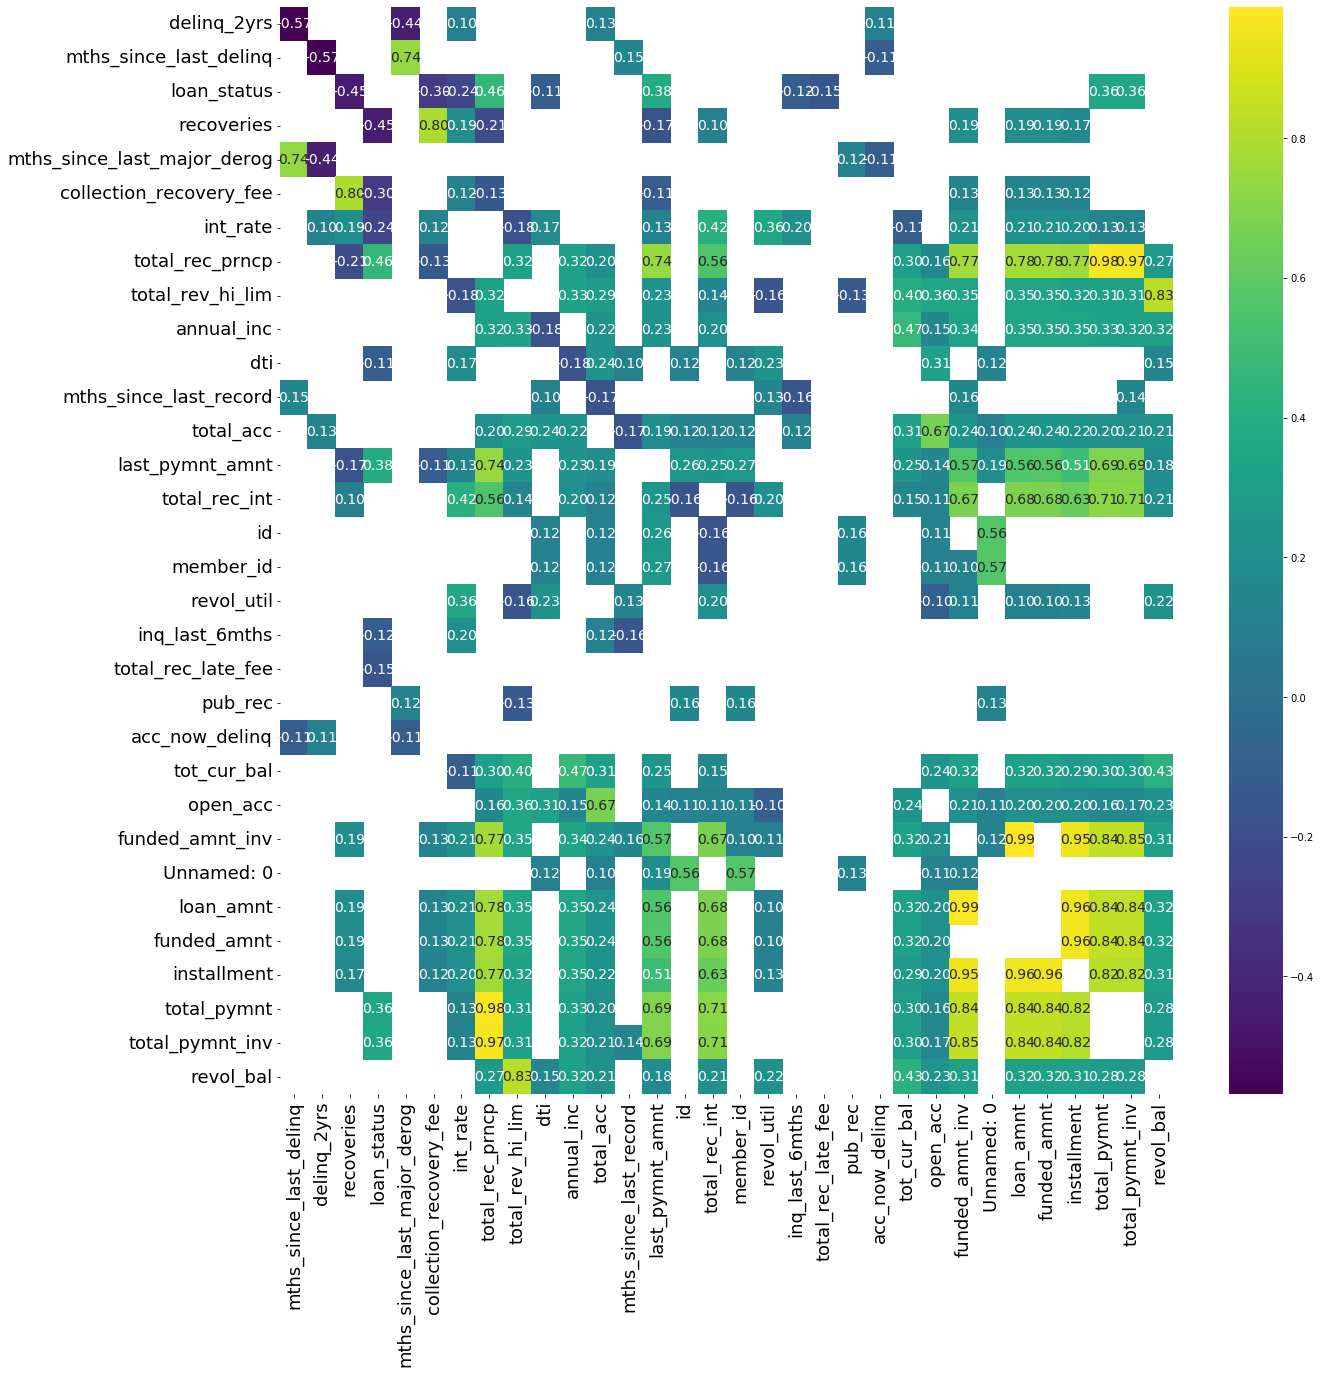

In [36]:
#show heatmap
plt.figure(figsize=(20, 20))
plot = sns.heatmap(
    trimmed_corr, 
    annot=True, 
    mask=mask,
    fmt=".2f", 
    cmap="viridis", 
    annot_kws={"size": 14})

plot.set_xticklabels(plot.get_xticklabels(), size=18)
plot.set_yticklabels(plot.get_yticklabels(), size=18)
plt.show()

In [38]:
affect_loan = high_corr.loc["loan_status"].abs().sort_values(ascending=True)
affect_loan

dti                        0.107257
inq_last_6mths             0.116393
total_rec_late_fee         0.152231
int_rate                   0.241059
collection_recovery_fee    0.300094
total_pymnt                0.355349
total_pymnt_inv            0.358588
last_pymnt_amnt            0.384781
recoveries                 0.445422
total_rec_prncp            0.460338
dtype: float64

Identify correlated features with a limit value of 0.9

In [44]:
threshold = 0.9
affect_coll = (high_corr.abs()
                        .loc[high_corr > threshold]
                        .loc[affect_loan.index, affect_loan.index]
                        .sort_values(ascending=True)
)
affect_coll

total_pymnt_inv  total_rec_prncp    0.969473
total_rec_prncp  total_pymnt_inv    0.969473
total_pymnt      total_rec_prncp    0.975030
total_rec_prncp  total_pymnt        0.975030
dtype: float64

In [45]:
left_index = affect_collision.index.get_level_values(0)
right_index = affect_collision.index.get_level_values(1)

def remove_collide_index(left_index, right_index):
    include, exclude = [], []

    for left, right in zip(left_index, right_index):
        if left not in include and left not in exclude:
            include.append(left)
        if right not in include and right not in exclude:
            exclude.append(right)
        
    return include, exclude


include_affect_col, exclude_affect_col = remove_collide_index(left_index, right_index)
include_affect_col, exclude_affect_col

(['total_pymnt_inv', 'total_pymnt'], ['total_rec_prncp'])

In [46]:
affect_num_cols = affect_loan[~affect_loan.index.isin(exclude_affect_col)].index.to_list()
affect_num_cols

['dti',
 'inq_last_6mths',
 'total_rec_late_fee',
 'int_rate',
 'collection_recovery_fee',
 'total_pymnt',
 'total_pymnt_inv',
 'last_pymnt_amnt',
 'recoveries']

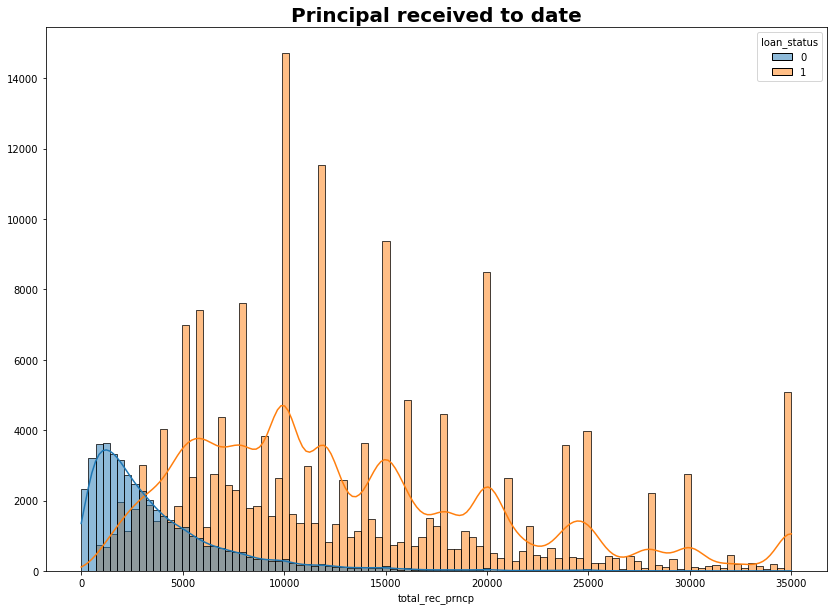

In [52]:
plot_dist(df=filter_df, x="total_rec_prncp", hue="loan_status", title="Principal received to date")

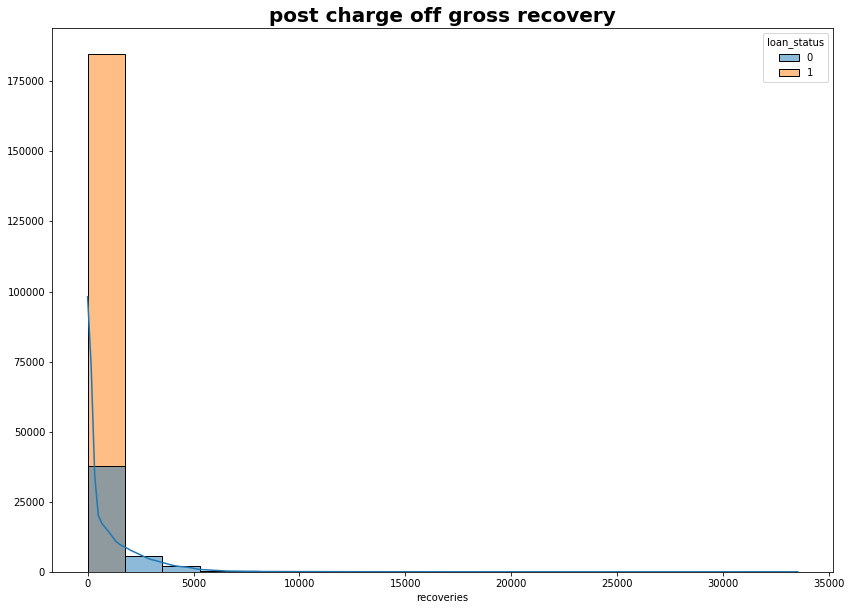

In [53]:
plot_dist(df=filter_df, x="recoveries", hue="loan_status", title="post charge off gross recovery")

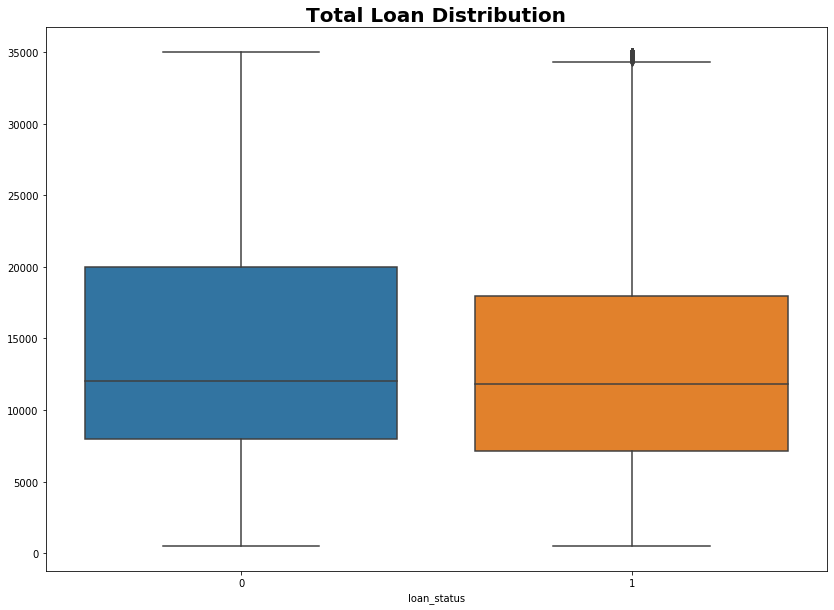

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,46056.0,14205.570393,8362.468087,500.0,8000.0,12000.0,20000.0,35000.0
1,184739.0,13214.394226,7949.030252,500.0,7125.0,11800.0,18000.0,35000.0


In [54]:
x, y = "loan_status", "loan_amnt"
plot_box(df=filter_df, x=x, y=y, title="Total Loan Distribution")
filter_df.groupby(x)[y].describe()

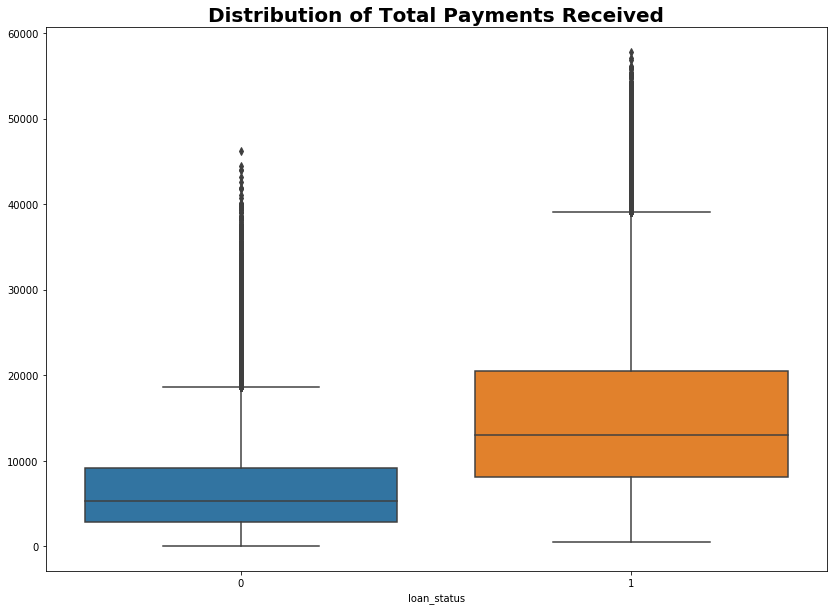

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,46056.0,6814.461231,5610.294962,0.00,2829.912500,5260.94000,9120.685,46199.44000
1,184739.0,15209.872007,9459.142043,526.33,8092.460697,12979.34106,20491.905,57777.57987


In [55]:
x, y = "loan_status", "total_pymnt"
plot_box(df=filter_df, x=x, y=y, title="Distribution of Total Payments Received")
filter_df.groupby(x)[y].describe()

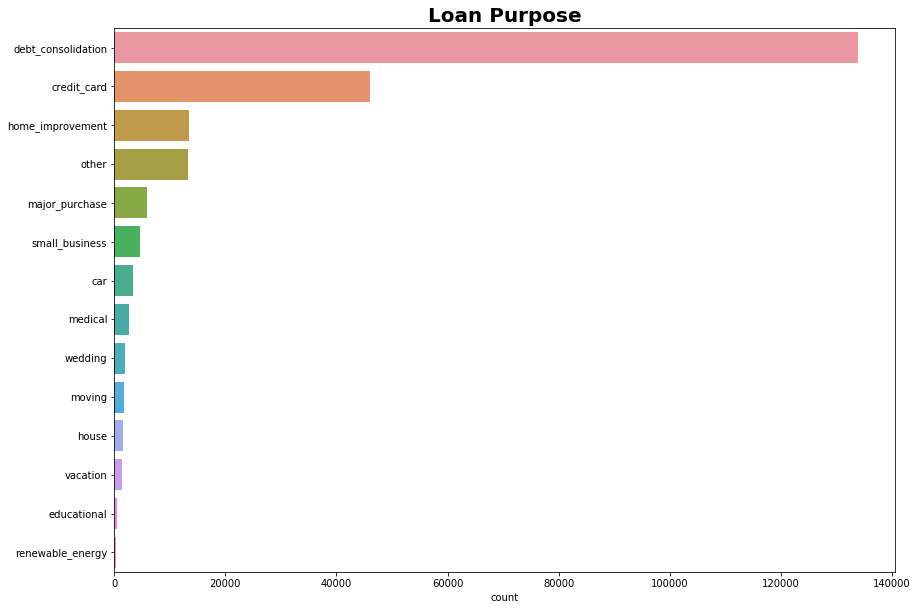

debt_consolidation    58.026%
credit_card           19.953%
home_improvement       5.826%
other                  5.764%
major_purchase         2.536%
small_business         2.019%
car                    1.499%
medical                1.145%
wedding                0.871%
moving                 0.801%
house                  0.649%
vacation               0.618%
educational            0.183%
renewable_energy       0.110%
Name: purpose, dtype: object


In [56]:
plot_sum(filter_df, y="purpose", title="Loan Purpose")

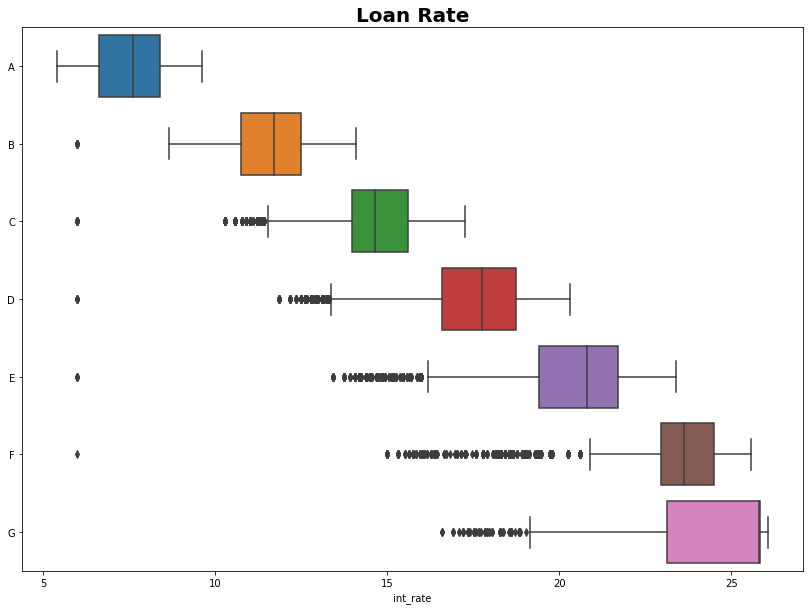

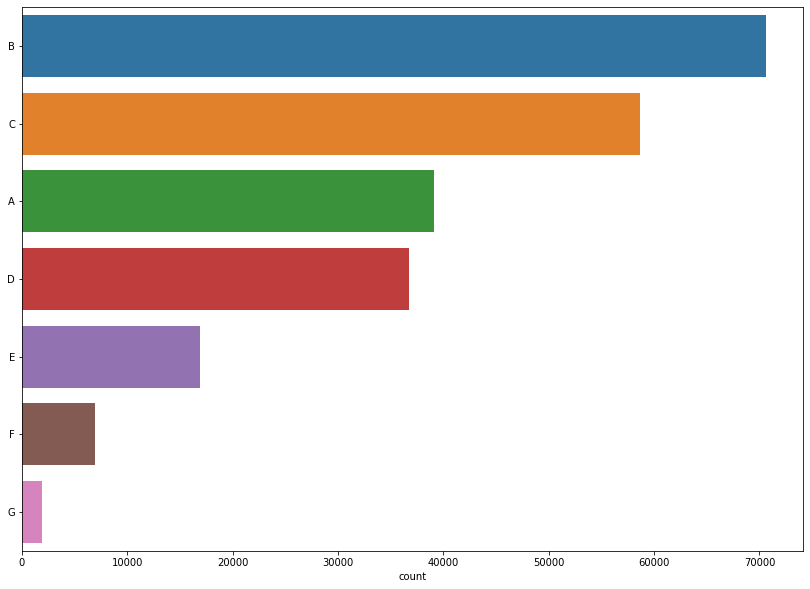

B    30.599%
C    25.402%
A    16.946%
D    15.919%
E     7.342%
F     2.988%
G     0.804%
Name: grade, dtype: object


,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
A,39110.0,7.545742,1.003571,5.42,6.62,7.62,8.39,9.63
B,70622.0,11.654616,1.281087,6.00,10.74,11.71,12.49,14.09
C,58626.0,14.767515,1.233598,6.00,13.98,14.64,15.61,17.27
D,36740.0,17.628885,1.484771,6.00,16.59,17.77,18.75,20.31
E,16945.0,20.341001,1.920465,6.00,19.42,20.80,21.70,23.40
F,6896.0,23.137195,2.097052,6.00,22.95,23.63,24.50,25.57
G,1856.0,24.191482,2.509841,16.59,23.13,25.80,25.83,26.06


In [57]:
x, y = "int_rate", "grade"
order = filter_df[y].sort_values().unique()
plot_box(filter_df, x=x, y=y, title="Loan Rate", order=order)
plot_sum(df=filter_df, y=y, title="")
filter_df.groupby(y)[x].describe()

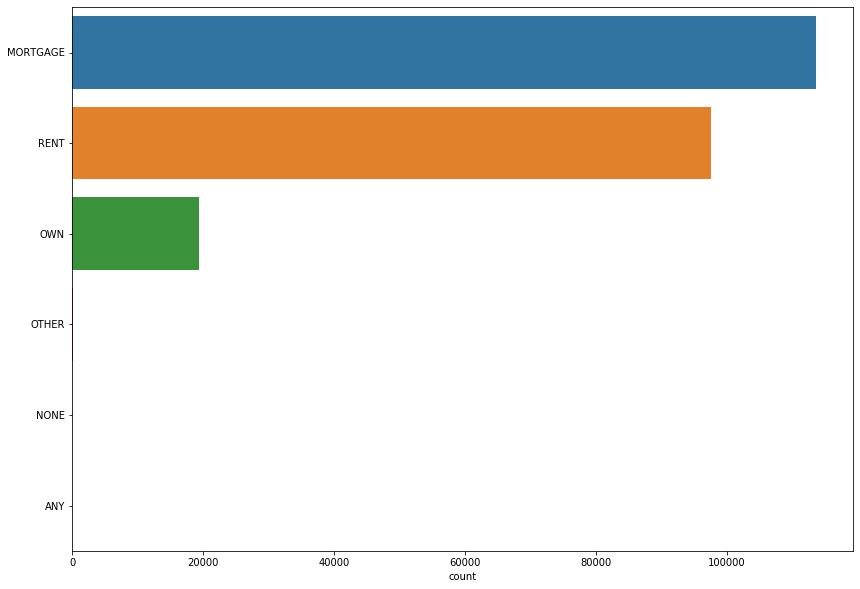

MORTGAGE    49.233%
RENT        42.291%
OWN          8.377%
OTHER        0.078%
NONE         0.021%
ANY          0.000%
Name: home_ownership, dtype: object


In [58]:
y = "home_ownership"
order = filter_df[y].sort_values().unique()
plot_sum(df=filter_df, y=y, title="")

**PREPROCESSING DATA**

In [59]:
#detailed information about data columns and rows
data_stat = pd.DataFrame()
data_stat.index = filter_df.columns
data_stat["unique_value"] = filter_df.nunique()
data_stat["missing_rate"] = filter_df.isna().mean()
data_stat["dtype"] = filter_df.dtypes
data_stat

,unique_value,missing_rate,dtype
Unnamed: 0,230795,0.000000,int64
id,230795,0.000000,int64
member_id,230795,0.000000,int64
loan_amnt,1308,0.000000,int64
funded_amnt,1311,0.000000,int64
...,...,...,...
all_util,0,1.000000,float64
total_rev_hi_lim,9021,0.288026,float64
inq_fi,0,1.000000,float64
total_cu_tl,0,1.000000,float64


In [60]:
#column where all data is missing
miss_col = data_stat[data_stat["missing_rate"] == 1].index.to_list()
print("Column where all data is missing: ")
print(miss_col)
print()

#columns with multiple categories
cat_col_stat = data_stat[data_stat["dtype"] == "object"]
vari_cat_col = cat_col_stat[cat_col_stat["unique_value"] > 1000].index.to_list()
print("Columns with multiple categories: ")
print(vari_cat_col)
print()

#column consisting of one value
single_valued_col = data_stat[data_stat["unique_value"] == 1].index.to_list()
print("Column consisting of one value: ")
print(single_valued_col)
print()

#unique column
vari_col = data_stat[data_stat["unique_value"] == filter_df.shape[0]].index.to_list()
print("Unique column: ")
print(vari_col)
print()

removed_features = miss_col + vari_col + vari_cat_col + single_valued_col

Column where all data is missing: 
['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']

Columns with multiple categories: 
['emp_title', 'url', 'desc', 'title']

Column consisting of one value: 
['policy_code', 'application_type']

Unique column: 
['Unnamed: 0', 'id', 'member_id', 'url']



In [61]:
#eliminate unused features
pre_df = filter_df.loc[:, ~filter_df.columns.isin(removed_features)].copy()
pre_df.shape

(230795, 49)

**CATEGORICAL FEATURES**

In [62]:
#columns with categorical data
cat_features = pre_df.select_dtypes(include=object).columns
cat_features

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d'],
      dtype='object')

In [63]:
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"]

for col in date_cols:
    print(pre_df[col].value_counts().iloc[:5])
    print()

Oct-14    8808
Jul-14    8614
Apr-14    6744
Nov-13    6665
Oct-13    6653
Name: issue_d, dtype: int64

Oct-00    1972
Oct-99    1837
Nov-00    1796
Oct-01    1779
Aug-00    1758
Name: earliest_cr_line, dtype: int64

Jul-15    11703
Mar-15    10087
Jun-15    10078
Apr-15    10051
Aug-15     9932
Name: last_pymnt_d, dtype: int64

Jan-16    93758
Dec-15    13753
Nov-15     8199
Sep-15     7942
Oct-15     7805
Name: last_credit_pull_d, dtype: int64

Feb-16    795
Mar-11    107
Apr-11    101
Feb-11     91
Jan-11     79
Name: next_pymnt_d, dtype: int64



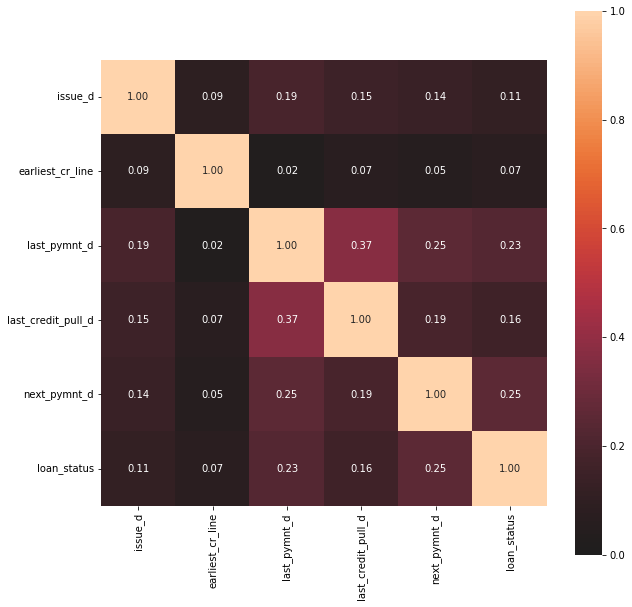

In [65]:
#correlation between dates and loan status
used_cols = date_cols + ["loan_status"] 
complete_correlation = associations(
    pre_df[used_cols], 
    filename='Date Correlation.png',
    figsize=(10,10)
)

In [66]:
#date feature we will use
affect_date_cols = ["issue_d", "last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"]
affect_date_cols

['issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'next_pymnt_d']

In [67]:
#Remove date features that do not have a strong correlation with loan status
unused_cols = ["earliest_cr_line"]
pre_df = pre_df.drop(columns=unused_cols, errors="ignore")
pre_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,Jan-15,171.62,NaN,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,Apr-13,119.66,NaN,Sep-13,0.0,NaN,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,Jun-14,649.91,NaN,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,Jan-15,357.48,NaN,Jan-15,0.0,NaN,0.0,NaN,NaN,NaN
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,...,Jan-15,161.03,NaN,Sep-15,0.0,NaN,0.0,NaN,NaN,NaN


In [68]:
other_cat_cols = cat_features[~cat_features.isin(date_cols)]
other_cat_cols

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'initial_list_status'],
      dtype='object')

In [69]:
pre_df.loc[:, other_cat_cols].head()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose,zip_code,addr_state,initial_list_status
0,36 months,B,B2,10+ years,RENT,Verified,n,credit_card,860xx,AZ,f
1,60 months,C,C4,< 1 year,RENT,Source Verified,n,car,309xx,GA,f
2,36 months,C,C5,10+ years,RENT,Not Verified,n,small_business,606xx,IL,f
3,36 months,C,C1,10+ years,RENT,Source Verified,n,other,917xx,CA,f
5,36 months,A,A4,3 years,RENT,Source Verified,n,wedding,852xx,AZ,f


In [ ]:
unused_cols = ["desc", "zip_code", "sub_grade", "title"]
pre_df = pre_df.drop(columns=unused_cols, errors="ignore")
pre_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,...,Jan-15,171.62,NaN,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,...,Apr-13,119.66,NaN,Sep-13,0.0,NaN,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,...,Jun-14,649.91,NaN,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,...,Jan-15,357.48,NaN,Jan-15,0.0,NaN,0.0,NaN,NaN,NaN
5,5000,5000,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.0,...,Jan-15,161.03,NaN,Sep-15,0.0,NaN,0.0,NaN,NaN,NaN


In [71]:
other_cat_cols = cat_features[~cat_features.isin(date_cols + unused_cols)]
other_cat_cols

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'initial_list_status'],
      dtype='object')

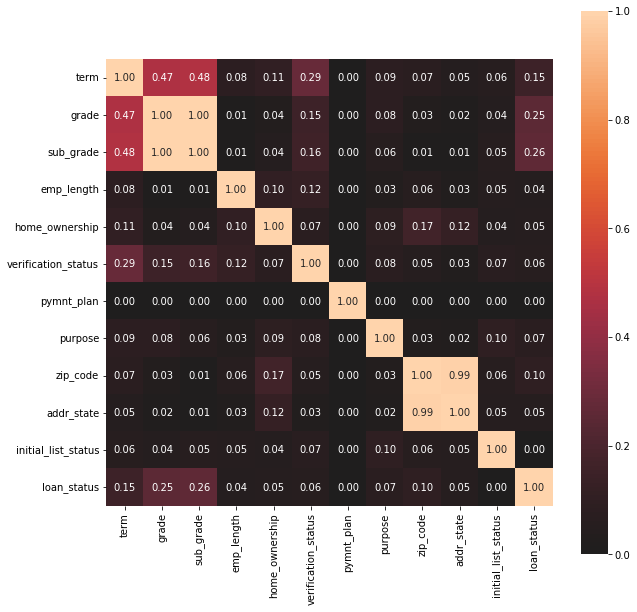

In [70]:
#correlation between categorical features and loan status
used_cols = other_cat_cols.to_list() + ["loan_status"]
complete_correlation = associations(
    pre_df[used_cols], 
    filename='Cat Correlation.png',
    figsize=(10,10)
)

In [72]:
#categorical features we will use
affect_cat_cols = ["grade", "term"]
affect_cat_cols

['grade', 'term']

In [73]:
#remove less influential features
used_cols = ["emp_title", "grade", "term"]
unused_cols = other_cat_cols[~other_cat_cols.isin(used_cols)]
pre_df = pre_df.drop(columns=unused_cols, errors="ignore")
pre_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,annual_inc,issue_d,loan_status,...,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,24000.0,Dec-11,1,...,Jan-15,171.62,NaN,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,30000.0,Dec-11,0,...,Apr-13,119.66,NaN,Sep-13,0.0,NaN,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,12252.0,Dec-11,1,...,Jun-14,649.91,NaN,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,49200.0,Dec-11,1,...,Jan-15,357.48,NaN,Jan-15,0.0,NaN,0.0,NaN,NaN,NaN
5,5000,5000,5000.0,36 months,7.90,156.46,A,36000.0,Dec-11,1,...,Jan-15,161.03,NaN,Sep-15,0.0,NaN,0.0,NaN,NaN,NaN


**FEATURES THATE CORRELATED WITH TARGET**

In [74]:
#the columns we will use
predictor_cols = affect_num_cols + affect_cat_cols + affect_date_cols
predictor_cols

['dti',
 'inq_last_6mths',
 'total_rec_late_fee',
 'int_rate',
 'collection_recovery_fee',
 'total_pymnt',
 'total_pymnt_inv',
 'last_pymnt_amnt',
 'recoveries',
 'grade',
 'term',
 'issue_d',
 'last_pymnt_d',
 'last_credit_pull_d',
 'next_pymnt_d']

**IMPUTATION MISSING VALUE**

In [75]:
pre_df[predictor_cols].isna().mean().sort_values(ascending=True)

dti                        0.000000
total_rec_late_fee         0.000000
int_rate                   0.000000
collection_recovery_fee    0.000000
total_pymnt                0.000000
total_pymnt_inv            0.000000
last_pymnt_amnt            0.000000
recoveries                 0.000000
grade                      0.000000
term                       0.000000
issue_d                    0.000000
last_credit_pull_d         0.000100
inq_last_6mths             0.000126
last_pymnt_d               0.001629
next_pymnt_d               0.984484
dtype: float64

In [84]:
#fill data with "no"
pre_df["next_pymnt_d"] = pre_df["next_pymnt_d"].fillna("no")
top_next_pyment_d = pre_df["next_pymnt_d"].value_counts().head()

pre_df["last_pymnt_d"] = pre_df["last_pymnt_d"].fillna("no")
pre_df["last_credit_pull_d"] = pre_df["last_credit_pull_d"].fillna("no")

In [85]:
#fill data with "mode" value
mode = pre_df["inq_last_6mths"].mode().values[0]
pre_df["inq_last_6mths"] = pre_df["inq_last_6mths"].fillna(mode)

In [88]:
#check again if there is still missing data
pre_df[predictor_cols].isna().mean().sort_values(ascending=True)

dti                        0.0
inq_last_6mths             0.0
total_rec_late_fee         0.0
int_rate                   0.0
collection_recovery_fee    0.0
total_pymnt                0.0
total_pymnt_inv            0.0
last_pymnt_amnt            0.0
recoveries                 0.0
grade                      0.0
term                       0.0
issue_d                    0.0
last_pymnt_d               0.0
last_credit_pull_d         0.0
next_pymnt_d               0.0
dtype: float64

**MODELING**

In [89]:
label = pre_df["loan_status"].copy()
features = pre_df[predictor_cols].copy()

print("Label shape:")
print(label.shape)

print("Features shape:")
print(features.shape)

Label shape:
(230795,)
Features shape:
(230795, 15)


In [90]:
num_features = features.select_dtypes(exclude="object")
cat_features = features.select_dtypes(include="object")

In [91]:
#numerical feature normalization
num_features = (num_features - num_features.mean()) / num_features.std()
num_features

,dti,inq_last_6mths,total_rec_late_fee,int_rate,collection_recovery_fee,total_pymnt,total_pymnt_inv,last_pymnt_amnt,recoveries
0,1.472931,0.078612,-0.139146,-0.716859,-0.149837,-0.812658,-0.800159,-0.822146,-0.222400
1,-2.000498,3.480063,-0.139146,0.340654,-0.140651,-1.326547,-1.310168,-0.829680,-0.071386
2,-0.994312,0.928975,-0.139146,0.498595,-0.149837,-1.115272,-1.099216,-0.752787,-0.222400
3,0.475868,0.078612,2.788316,-0.066786,-0.149837,-0.138548,-0.123979,-0.795193,-0.222400
5,-0.671081,1.779338,-0.139146,-1.346331,-0.149837,-0.836983,-0.821350,-0.823681,-0.222400
...,...,...,...,...,...,...,...,...,...
466276,-0.530319,-0.771750,-0.139146,1.022774,-0.053887,-1.218395,-1.202181,-0.815471,1.273040
466277,-0.784472,-0.771750,-0.139146,-1.346331,-0.149837,-0.836953,-0.822146,-0.765357,-0.222400
466278,-0.622857,-0.771750,-0.139146,1.022774,-0.149837,-0.120771,-0.106227,-0.049229,-0.222400
466281,0.273848,3.480063,-0.139146,1.416480,-0.149837,-0.937959,-0.922172,-0.844495,-0.222400


In [92]:
#OneHotEncode categorical feature
cat_features = pd.get_dummies(cat_features)
cat_features

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,issue_d_Apr-08,...,next_pymnt_d_Oct-15,next_pymnt_d_Sep-08,next_pymnt_d_Sep-09,next_pymnt_d_Sep-10,next_pymnt_d_Sep-11,next_pymnt_d_Sep-12,next_pymnt_d_Sep-13,next_pymnt_d_Sep-14,next_pymnt_d_Sep-15,next_pymnt_d_no
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466276,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
466277,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
466278,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
466281,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [95]:
#merge features
features_full = pd.concat([num_features, cat_features], axis=1)
features_full.shape

(230795, 412)

Split Data

In [98]:
X_train, X_test, y_train, y_test = train_test_split(features_full, label, test_size=0.2, random_state=42, stratify=label)
X_train.shape, y_train.shape

((184636, 412), (184636,))

In [99]:
logres = LogisticRegression(max_iter=500, solver="sag", class_weight="balanced", n_jobs=-1)
logres

LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1,
                   solver='sag')

In [102]:
logres.fit(X_train, y_train) #ERROR

KeyboardInterrupt: ignored

**SAVING MODEL**

In [103]:
joblib.dump(logres, "logres.z")

['logres.z']

In [104]:
logres = joblib.load("logres.z")

**MODEL EVALUATION**

In [105]:
test_label_counts = y_test.value_counts()
test_label_counts

1    36948
0     9211
Name: loan_status, dtype: int64

In [106]:
test_label_counts.max() / test_label_counts.sum()

0.8004506163478412

In [121]:
logres.score(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


KeyboardInterrupt: ignored

In [109]:
report = classification_report(y_true=y_train, y_pred=logres.predict(X_train))
print(report) #ERROR

AttributeError: ignored

In [110]:
logres.score(X_test, y_test) #ERROR

AttributeError: ignored

In [ ]:
report = classification_report(y_true=y_test, y_pred=logres.predict(X_test))
print(report) #ERROR

AttributeError: ignored

In [118]:
conf = confusion_matrix(y_true=y_test, y_pred=logres.predict(X_test)) #ERROR

AttributeError: ignored

In [111]:
plt.figure(figsize=(10, 10))
sns.heatmap(conf, annot=True, fmt="g")
plt.show() #ERROR

NameError: ignored

<Figure size 720x720 with 0 Axes>